In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_train = pd.read_csv("final_training.csv")
df_test = pd.read_csv("final_testing.csv")


sex_map = {"male": 0, "female": 1}
df_train["Sex"] = df_train["Sex"].map(sex_map)
df_test["Sex"] = df_test["Sex"].map(sex_map)


print(df_train["Sex"].value_counts())
print(df_test["Sex"].value_counts())


Sex
0    577
1    314
Name: count, dtype: int64
Sex
0    266
1    152
Name: count, dtype: int64


In [95]:
embarked_train = pd.get_dummies(df_train["Embarked"], prefix="Embarked")
embarked_test = pd.get_dummies(df_test["Embarked"], prefix="Embarked")

embarked_train, embarked_test = embarked_train.align(embarked_test, join="outer", axis=1, fill_value=0)

df_train = pd.concat([df_train.drop("Embarked", axis=1), embarked_train], axis=1)
df_test = pd.concat([df_test.drop("Embarked", axis=1), embarked_test], axis=1)


In [96]:
df_train[["Embarked_C","Embarked_Q","Embarked_S"]] = df_train[["Embarked_C","Embarked_Q","Embarked_S"]].astype(int)
df_test[["Embarked_C","Embarked_Q","Embarked_S"]] = df_test[["Embarked_C","Embarked_Q","Embarked_S"]].astype(int)

In [97]:
print(df_train.columns)
print(df_test.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Name Length', 'AgeEstimated', 'isAlone', 'Ticket_Prefix', 'CabinInfo',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Name Length', 'AgeEstimated', 'isAlone', 'Ticket_Prefix', 'CabinInfo',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [98]:
df_train.drop(columns=["Ticket_Prefix"], inplace=True)
df_test.drop(columns=["Ticket_Prefix"], inplace=True)

In [99]:
# replace fare by log of fare

df_train["Fare"] = df_train["Fare"] + 1
df_test["Fare"] = df_test["Fare"] + 1

df_train["Fare"] = df_train["Fare"].apply(lambda x: np.log(x))
df_test["Fare"] = df_test["Fare"].apply(lambda x: np.log(x))

In [100]:
print(df_train.columns)
print(df_test.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Name Length', 'AgeEstimated', 'isAlone', 'CabinInfo', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Name Length', 'AgeEstimated', 'isAlone', 'CabinInfo', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [101]:
print(df_train.isna().sum())
print(df_test.isna().sum())

Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Name Length     0
AgeEstimated    0
isAlone         0
CabinInfo       0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64
PassengerId     0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Name Length     0
AgeEstimated    0
isAlone         0
CabinInfo       0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64


c:\working\Titanic-Machine_Learning_from_Disaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:59:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


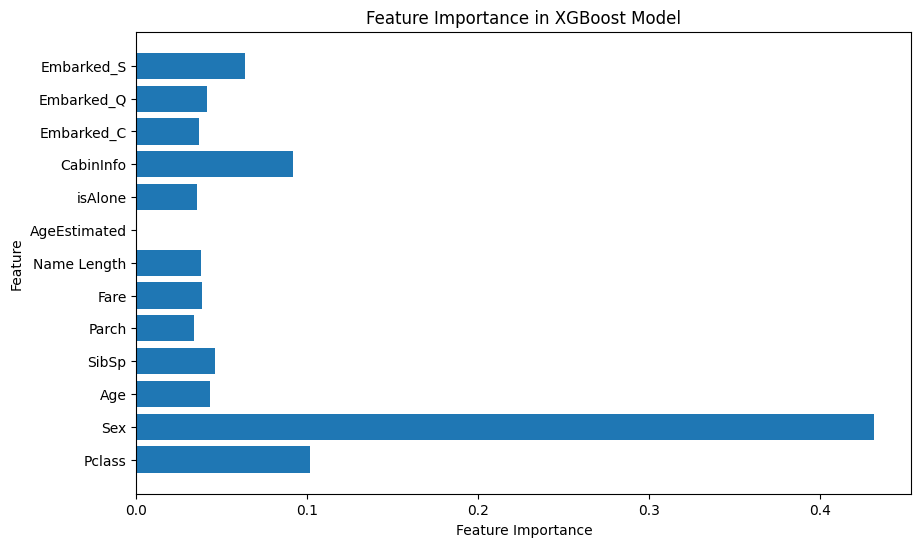

Validation Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       110
           1       0.77      0.71      0.74        69

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [102]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

y = df_train["Survived"]
X = df_train.drop("Survived", axis=1)

passenger_ids = df_test["PassengerId"] if "PassengerId" in df_test.columns else None
X_test = df_test.drop("PassengerId", axis=1, errors="ignore")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize XGBoost
model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    min_child_weight=5,
    eval_metric="logloss",
)

# Train
model.fit(X_train, y_train)

# plot importance of features
plt.figure(figsize=(10,6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in XGBoost Model")
plt.show()

# Validate
y_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

# Predict on test set
y_test_pred = model.predict(X_test)


In [ ]:
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred
})
submission.to_csv("xgb_submission_best.csv", index=False)
# this produces a score of 0.78947 on Kaggle

In [105]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

# 1. Random Forest
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# 3. Logistic Regression
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000
)

# 4. Support Vector Machine
svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    random_state=42,
    probability=True  # For ensemble methods
)

# 5. LightGBM (often faster than XGBoost)
lgb_model = LGBMClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

# 6. CatBoost
cat_model = CatBoostClassifier(
    iterations=300,
    depth=4,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

# 7. Ensemble Model (Voting)
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('gb', gb_model),
        ('lgb', lgb_model),
        ('lr', lr_model)
    ],
    voting='soft'  # Use predicted probabilities
)

# Train and evaluate different models
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Logistic Regression': lr_model,
    'SVM': svm_model,
    'LightGBM': lgb_model,
    'CatBoost': cat_model,
    'Voting Ensemble': voting_model
}

best_model = None
best_score = 0

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{name} Validation Accuracy: {accuracy:.4f}")
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = model
        best_name = name

print(f"\nBest model: {best_name} with accuracy: {best_score:.4f}")

# Use the best model for final predictions
y_test_pred_best = best_model.predict(X_test)


Training Random Forest...
Random Forest Validation Accuracy: 0.7821

Training Gradient Boosting...
Gradient Boosting Validation Accuracy: 0.7933

Training Logistic Regression...
Logistic Regression Validation Accuracy: 0.8045

Training SVM...
SVM Validation Accuracy: 0.7095

Training LightGBM...
LightGBM Validation Accuracy: 0.8156

Training CatBoost...
CatBoost Validation Accuracy: 0.8212

Training Voting Ensemble...
Voting Ensemble Validation Accuracy: 0.8101

Best model: CatBoost with accuracy: 0.8212


Using CatBoost model with validation accuracy: 0.8212
CatBoost submission saved as 'catboost_submission.csv'

Optimizing CatBoost hyperparameters...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best CatBoost parameters: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Best CV score: 0.8358
Optimized CatBoost submission saved as 'catboost_optimized_submission.csv'


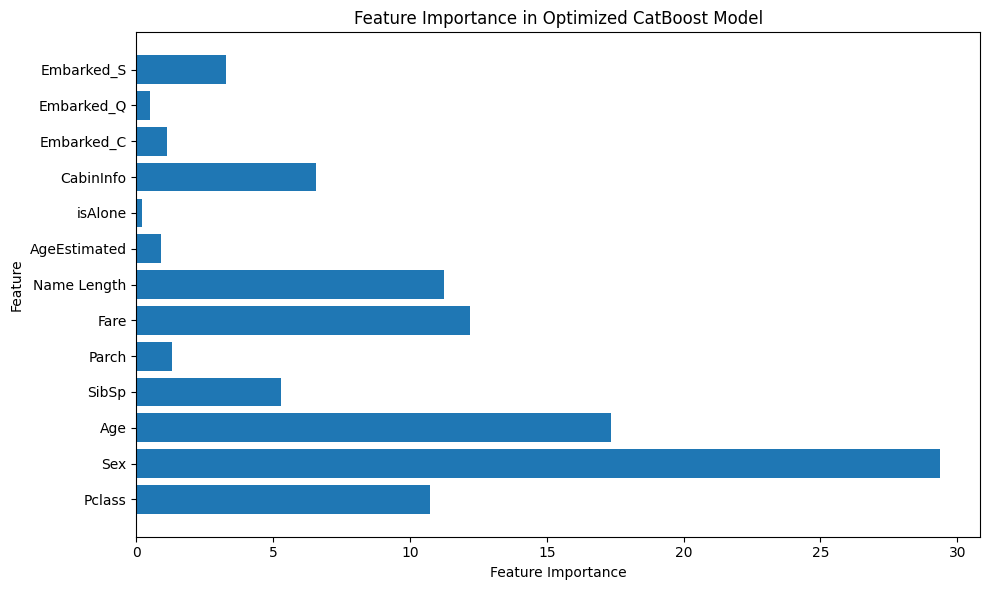

In [106]:
# Use CatBoost as the final model and create submission
print(f"Using CatBoost model with validation accuracy: {best_score:.4f}")

# Create submission with CatBoost
submission_catboost = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_test_pred_best
})
submission_catboost.to_csv("catboost_submission.csv", index=False)
print("CatBoost submission saved as 'catboost_submission.csv'")

# Optional: Fine-tune CatBoost further
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for CatBoost
catboost_params = {
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'iterations': [300, 500, 700],
    'l2_leaf_reg': [1, 3, 5]
}

print("\nOptimizing CatBoost hyperparameters...")
catboost_grid = GridSearchCV(
    CatBoostClassifier(random_seed=42, verbose=False),
    catboost_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

catboost_grid.fit(X_train, y_train)

print(f"Best CatBoost parameters: {catboost_grid.best_params_}")
print(f"Best CV score: {catboost_grid.best_score_:.4f}")

# Train final optimized model on full training data
final_catboost = CatBoostClassifier(
    **catboost_grid.best_params_,
    random_seed=42,
    verbose=False
)

final_catboost.fit(X, y)  # Train on full dataset

# Final predictions
y_final_pred = final_catboost.predict(X_test)

# Create final submission
final_submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_final_pred
})
final_submission.to_csv("catboost_optimized_submission.csv", index=False)
print("Optimized CatBoost submission saved as 'catboost_optimized_submission.csv'")

# Feature importance plot for CatBoost
plt.figure(figsize=(10, 6))
feature_importance = final_catboost.get_feature_importance()
plt.barh(X.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Optimized CatBoost Model")
plt.tight_layout()
plt.show()

Optimizing Random Forest model...

Optimizing Random Forest hyperparameters...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Random Forest parameters: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV score: 0.8358
Optimized Random Forest submission saved as 'random_forest_optimized_submission.csv'


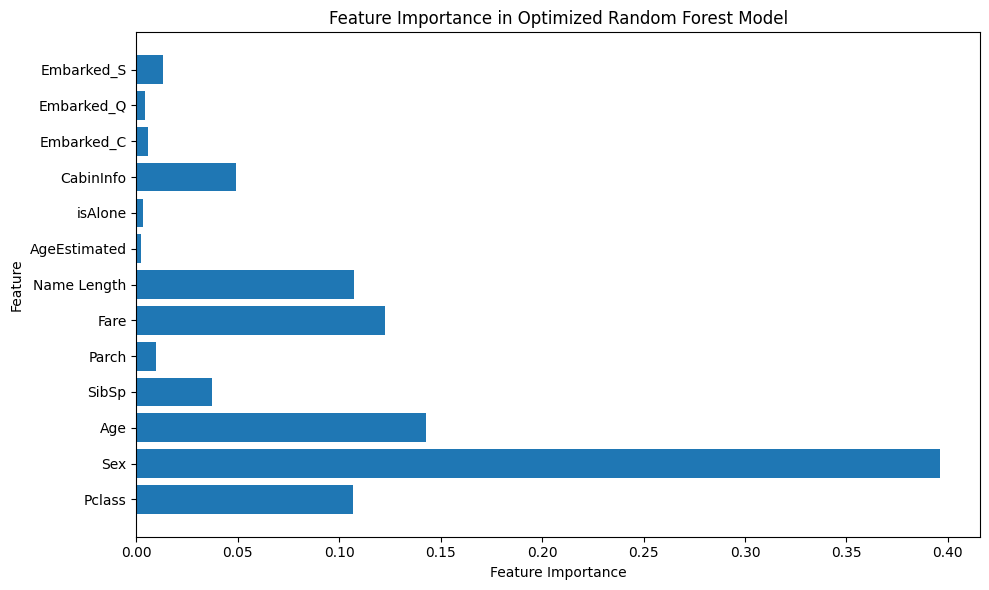

Random Forest validation accuracy: 0.9218


In [107]:
# Random Forest optimization and submission
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print("Optimizing Random Forest model...")

# Hyperparameter tuning for Random Forest
rf_params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("\nOptimizing Random Forest hyperparameters...")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# Train final optimized Random Forest model on full training data
final_rf = RandomForestClassifier(
    **rf_grid.best_params_,
    random_state=42
)

final_rf.fit(X, y)  # Train on full dataset

# Final predictions
y_rf_pred = final_rf.predict(X_test)

# Create Random Forest submission
rf_submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_rf_pred
})
rf_submission.to_csv("random_forest_optimized_submission.csv", index=False)
print("Optimized Random Forest submission saved as 'random_forest_optimized_submission.csv'")

# Feature importance plot for Random Forest
plt.figure(figsize=(10, 6))
rf_feature_importance = final_rf.feature_importances_
plt.barh(X.columns, rf_feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Optimized Random Forest Model")
plt.tight_layout()
plt.show()

# Validation accuracy on validation set
y_rf_val_pred = final_rf.predict(X_val)
rf_val_accuracy = accuracy_score(y_val, y_rf_val_pred)
print(f"Random Forest validation accuracy: {rf_val_accuracy:.4f}")

Optimizing LightGBM model...

Optimizing LightGBM hyperparameters...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best LightGBM parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'num_leaves': 31, 'subsample': 0.8}
Best CV score: 0.8470
Optimized LightGBM submission saved as 'lightgbm_optimized_submission.csv'


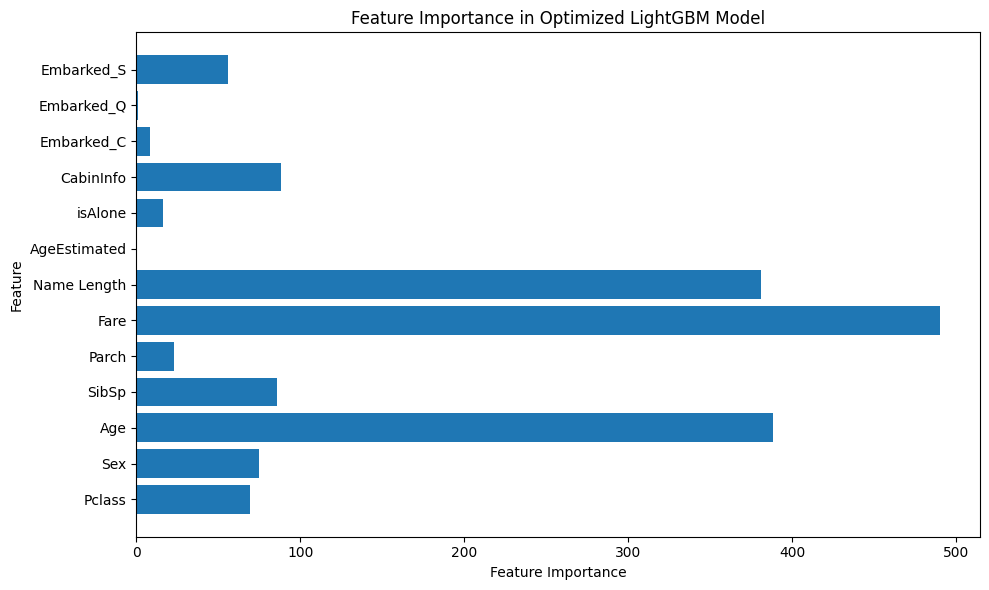

LightGBM validation accuracy: 0.9050


In [109]:
# LightGBM optimization and submission
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

print("Optimizing LightGBM model...")

# Hyperparameter tuning for LightGBM
lgb_params = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 4, 6],
    'learning_rate': [0.05],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'num_leaves': [31, 50]
}

print("\nOptimizing LightGBM hyperparameters...")
lgb_grid = GridSearchCV(
    LGBMClassifier(random_state=42, verbose=-1),
    lgb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

lgb_grid.fit(X_train, y_train)

print(f"Best LightGBM parameters: {lgb_grid.best_params_}")
print(f"Best CV score: {lgb_grid.best_score_:.4f}")

# Train final optimized LightGBM model on full training data
final_lgb = LGBMClassifier(
    **lgb_grid.best_params_,
    random_state=42,
    verbose=-1
)

final_lgb.fit(X, y)  # Train on full dataset

# Final predictions
y_lgb_pred = final_lgb.predict(X_test)

# Create LightGBM submission
lgb_submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_lgb_pred
})
lgb_submission.to_csv("lightgbm_optimized_submission.csv", index=False)
print("Optimized LightGBM submission saved as 'lightgbm_optimized_submission.csv'")

# Feature importance plot for LightGBM
plt.figure(figsize=(10, 6))
lgb_feature_importance = final_lgb.feature_importances_
plt.barh(X.columns, lgb_feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Optimized LightGBM Model")
plt.tight_layout()
plt.show()

# Validation accuracy on validation set
y_lgb_val_pred = final_lgb.predict(X_val)
lgb_val_accuracy = accuracy_score(y_val, y_lgb_val_pred)
print(f"LightGBM validation accuracy: {lgb_val_accuracy:.4f}")

In [110]:
# Model Stacking - Combine multiple models for better performance
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

print("Creating Stacked Ensemble Model...")

# Base models (use the ones we already trained)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=500, max_depth=6, min_samples_split=5, 
                                  min_samples_leaf=2, random_state=42)),
    ('lgb', LGBMClassifier(n_estimators=300, max_depth=4, learning_rate=0.05, 
                           subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1)),
    ('cat', CatBoostClassifier(iterations=300, depth=4, learning_rate=0.1, 
                               random_seed=42, verbose=False)),
    ('xgb', XGBClassifier(n_estimators=500, max_depth=4, learning_rate=0.05, 
                          subsample=0.8, colsample_bytree=0.8, random_state=42, 
                          use_label_encoder=False, eval_metric="logloss"))
]

# Meta-learner (final model that learns from base model predictions)
meta_learner = LogisticRegression(random_state=42, max_iter=1000)

# Create stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,  # 5-fold cross-validation for base model predictions
    stack_method='predict_proba',  # Use probabilities instead of hard predictions
    n_jobs=-1
)

# Train stacking model
print("Training stacked ensemble...")
stacking_model.fit(X_train, y_train)

# Evaluate on validation set
y_stack_pred = stacking_model.predict(X_val)
stack_accuracy = accuracy_score(y_val, y_stack_pred)
print(f"Stacking Model Validation Accuracy: {stack_accuracy:.4f}")

# Cross-validation score
cv_scores = cross_val_score(stacking_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train on full dataset for final predictions
print("Training final stacked model on full dataset...")
final_stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

final_stacking_model.fit(X, y)

# Final predictions
y_stack_final_pred = final_stacking_model.predict(X_test)

# Create submission
stacking_submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_stack_final_pred
})
stacking_submission.to_csv("stacking_ensemble_submission.csv", index=False)
print("Stacking ensemble submission saved as 'stacking_ensemble_submission.csv'")

# Compare with individual models
print("\n=== Model Comparison ===")
print(f"Stacking Ensemble: {stack_accuracy:.4f}")
# Add validation scores from your previous models for comparison

Creating Stacked Ensemble Model...
Training stacked ensemble...
Stacking Model Validation Accuracy: 0.8156
Cross-validation mean accuracy: 0.8272 (+/- 0.0327)
Training final stacked model on full dataset...
Stacking ensemble submission saved as 'stacking_ensemble_submission.csv'

=== Model Comparison ===
Stacking Ensemble: 0.8156


In [111]:
# Try different meta-learners
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

meta_learners = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric="logloss")
}

best_stack_score = 0
best_stack_model = None
best_stack_name = None

for name, meta_model in meta_learners.items():
    print(f"\nTesting stacking with {name} as meta-learner...")
    
    stack_model = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    stack_model.fit(X_train, y_train)
    y_pred = stack_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Validation Accuracy with {name}: {accuracy:.4f}")
    
    if accuracy > best_stack_score:
        best_stack_score = accuracy
        best_stack_model = stack_model
        best_stack_name = name

print(f"\nBest stacking model: {best_stack_name} with accuracy: {best_stack_score:.4f}")

# Use best stacking model for final submission
best_stack_model.fit(X, y)
y_best_stack_pred = best_stack_model.predict(X_test)

best_stacking_submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": y_best_stack_pred
})
best_stacking_submission.to_csv("best_stacking_submission.csv", index=False)
print("Best stacking submission saved as 'best_stacking_submission.csv'")


Testing stacking with Logistic Regression as meta-learner...
Validation Accuracy with Logistic Regression: 0.8156

Testing stacking with Random Forest as meta-learner...
Validation Accuracy with Random Forest: 0.7933

Testing stacking with XGBoost as meta-learner...


c:\working\Titanic-Machine_Learning_from_Disaster\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:25:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy with XGBoost: 0.7598

Best stacking model: Logistic Regression with accuracy: 0.8156
Best stacking submission saved as 'best_stacking_submission.csv'
